# Quantium Data Analysis

In [1]:
#Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import t

%matplotlib inline

In [2]:
'''The merged data from task 1 can be used in task 2. However, when I check the data Quantium provided in task 2, the DATE
attritbute is incorrect for task 1. So I used the new data they provided in task 2'''
data = pd.read_csv('QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
#Change data type to save memory
int64 =  data.select_dtypes(include=['int64']).columns.tolist() 
data[int64] = data[int64].astype('int32')

data['TOT_SALES'] = data['TOT_SALES'].astype('float16') #Change float64 to float16

#Change DATE to datetime data
data['DATE'] = pd.to_datetime(data['DATE'],format = '%Y-%m-%d')

#Change STORE_NBR to category data
data['STORE_NBR'] = data['STORE_NBR'].astype('category')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int32         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  category      
 3   TXN_ID            264834 non-null  int32         
 4   PROD_NBR          264834 non-null  int32         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int32         
 7   TOT_SALES         264834 non-null  float16       
 8   PACK_SIZE         264834 non-null  int32         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
dtypes: category(1), datetime64[ns](1), float16(1), int32(5), object(4)
memory usage: 16.2+ MB


The client has selected store numbers 77, 86 and 88 as trial stores and want 
control stores to be established stores that are operational for the entire 
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present 
throughout the pre-trial period.

In [6]:
#Add a new month ID column in the data with format yyyymm
data['MONTH_ID'] = data['DATE'].dt.to_period('M')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH_ID
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.000000,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.699219,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.599609,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.000000,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.900391,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


As we only considered stores that have sales every month over July 2018 to June 2019, stores that do not satisfy the condition need to be dropped

In [7]:
count_months = data.groupby('STORE_NBR')['MONTH_ID'].nunique()
count_months = count_months[count_months < 12]
store_to_drop = pd.DataFrame(count_months).index

For each store and month calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit.

In [8]:
data = data.loc[~data.STORE_NBR.isin(store_to_drop)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264645 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264645 non-null  int32         
 1   DATE              264645 non-null  datetime64[ns]
 2   STORE_NBR         264645 non-null  category      
 3   TXN_ID            264645 non-null  int32         
 4   PROD_NBR          264645 non-null  int32         
 5   PROD_NAME         264645 non-null  object        
 6   PROD_QTY          264645 non-null  int32         
 7   TOT_SALES         264645 non-null  float16       
 8   PACK_SIZE         264645 non-null  int32         
 9   BRAND             264645 non-null  object        
 10  LIFESTAGE         264645 non-null  object        
 11  PREMIUM_CUSTOMER  264645 non-null  object        
 12  MONTH_ID          264645 non-null  period[M]     
dtypes: category(1), datetime64[ns](1), float16(1), int32(5), ob

In [9]:
#total sales for each store and month
data['MONTHLY_SALES'] = data.groupby(['STORE_NBR','MONTH_ID'])['TOT_SALES'].transform('sum')

#number of customer for each store and month
data['MONTHLY_CUSTOMER'] = data.groupby(['STORE_NBR','MONTH_ID'])['LYLTY_CARD_NBR'].transform('nunique')

#transactions per customer for each store and month
data['MONTHLY_TRANSACTION'] = data.groupby(['STORE_NBR','MONTH_ID'])['TXN_ID'].transform('count') #Count number of transaction
data['TRANSACTION_PER_CUSTOMER'] = data['MONTHLY_TRANSACTION']/data['MONTHLY_CUSTOMER'] #Number of transaction per customer

#chips per customer for each store and month
data['MONTHLY_QTY'] = data.groupby(['STORE_NBR','MONTH_ID'])['PROD_QTY'].transform('sum') #Total product quantity
data['QTY_PER_CUSTOMER'] = data['MONTHLY_QTY']/data['MONTHLY_CUSTOMER'] #No of chips per customer

#average price per unit
data['AVERAGE_PRICE'] =data['MONTHLY_SALES']/data['MONTHLY_QTY']

In [10]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH_ID,MONTHLY_SALES,MONTHLY_CUSTOMER,MONTHLY_TRANSACTION,TRANSACTION_PER_CUSTOMER,MONTHLY_QTY,QTY_PER_CUSTOMER,AVERAGE_PRICE
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.000000,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10,188.125,44,45,1.022727,58,1.318182,3.243534
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.699219,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09,278.750,59,62,1.050847,75,1.271186,3.716667
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.599609,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03,192.875,45,49,1.088889,58,1.288889,3.325431
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.000000,175,NATURAL,YOUNG FAMILIES,Budget,2019-03,192.875,45,49,1.088889,58,1.288889,3.325431
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.900391,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11,192.625,46,47,1.021739,57,1.239130,3.379386


Filter to the pretrial period

In [11]:
pre_trial = data[data.MONTH_ID < '2019-02']

Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

In [12]:
metric_columns = ['STORE_NBR','MONTH_ID','MONTHLY_SALES','MONTHLY_CUSTOMER','TRANSACTION_PER_CUSTOMER','QTY_PER_CUSTOMER',
                 'AVERAGE_PRICE']
store_num = np.unique(pre_trial['STORE_NBR'])
input_data = pre_trial.loc[:,metric_columns].set_index(['STORE_NBR','MONTH_ID'])
input_data.sort_values(by = ['STORE_NBR','MONTH_ID'],ascending = True, inplace = True)
input_data.drop_duplicates(inplace = True, keep = 'first')

#Function to calculate correlation for a measure, looping through each control store
def cal_corr(input_data, metric_col, store_comparison):
    #Select Store_NBR, Month_ID, and the metric used to calculate correlation on
    metric = input_data[[metric_col]]

    #Loop through each store, calculate correlation
    trial_store = metric.loc[store_comparison]
    series = []
    for i in metric.index:
        corr = trial_store.corrwith(metric.loc[i[0]])
        series.append(corr)
    result = pd.DataFrame(series)
    result.index = metric.index
    result.index = [i[0] for i in result.index] #Select only STORE_NBR as index
    result.index.name = 'STORE_NBR'
    result = result.abs() #Make the correlation ranges from 0 to 1
    result.drop_duplicates(inplace = True)
    result.rename(columns={metric_col:'CORR'},inplace = True)
    return result

In [13]:
#Test if the function work
a = cal_corr(input_data,'MONTHLY_SALES',77)
a.head()

,CORR
STORE_NBR,
1,0.076171
2,0.262724
3,0.805021
4,0.262994
5,0.110910


It works! Now let's create another function to calculate magnitude

In [14]:
def cal_magnitude(input_data, metric_col, store_comparison):  
    #Select Store_NBR, Month_ID, and the metric used to calculate correlation on
    metric = input_data[[metric_col]]
    metric.reset_index(inplace = True)
    #Loop through each store, calculate correlation
    trial_store = metric.loc[metric['STORE_NBR']==store_comparison, metric_col]
    trial_store.reset_index(drop=True, inplace = True)
    series = []
    store_series = []
    
    for i in store_num:
        control_store = metric.loc[metric['STORE_NBR']==i, metric_col]
        control_store.reset_index(drop=True,inplace = True) #Same index with trial_store
        mag = abs(control_store-trial_store) #Subtraction of data records in same index
        mean_mag = np.mean(1-(mag-min(mag))/(max(mag)-min(mag)))
        series.append(mean_mag)
        store_series.append(i)
    result = pd.DataFrame({'STORE_NBR':store_series, 'MAGNITUDE':series})
    return result

In [15]:
b = cal_magnitude(input_data,'MONTHLY_SALES',77)
b.head()

C:\Users\workt\anaconda3\lib\site-packages\pandas\core\nanops.py:146: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


,STORE_NBR,MAGNITUDE
0,1,0.408447
1,2,0.590332
2,3,0.522949
3,4,0.645996
4,5,0.516602


Now let's use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores.

## Trial Store 77

### Select control store

In [51]:
#Calculate correlations against store 77 using total sales and number of customers
trial_store = 77
corr_sales = cal_corr(input_data,'MONTHLY_SALES',trial_store)
corr_customers = cal_corr(input_data,'MONTHLY_CUSTOMER',trial_store)

#Calculate magnitude distance against store 77 using total sales and number of customers
mag_sales = cal_magnitude(input_data,'MONTHLY_SALES',trial_store)
mag_customers = cal_magnitude(input_data,'MONTHLY_CUSTOMER',trial_store)

C:\Users\workt\anaconda3\lib\site-packages\pandas\core\nanops.py:146: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


We'll need to combine all the score calculated using our function to create a composite score to rank on.
Let's take a simpled average of the correlation and magnitude scores for each driver.

In [52]:
#Merge sales score
score_sales = corr_sales.merge(mag_sales, how = 'left', on = 'STORE_NBR')
#Merge no of customer score
score_customers = corr_customers.merge(mag_customers, how = 'left', on = 'STORE_NBR')

In [53]:
#Drop 77
index_drop = score_sales[score_sales['STORE_NBR']==trial_store].index
score_sales.drop(index_drop, inplace = True)
#Calculate control score for sales
score_sales['SCORE_SALES'] = (score_sales['CORR'] + score_sales['MAGNITUDE'])/2
score_sales.head()

,STORE_NBR,CORR,MAGNITUDE,SCORE_SALES
0,1,0.076171,0.408447,0.242309
1,2,0.262724,0.590332,0.426528
2,3,0.805021,0.522949,0.663985
3,4,0.262994,0.645996,0.454495
4,5,0.110910,0.516602,0.313756


Now we have a score for each of total number of sales and number of customers. Let's combine the two via a simple average

In [54]:
#Drop store 77
score_customers.drop(index_drop, inplace = True)
#Create control_store column
score_customers['SCORE_CUSTOMERS'] = (score_customers['CORR'] + score_customers['MAGNITUDE'])/2
score_customers.head()

,STORE_NBR,CORR,MAGNITUDE,SCORE_CUSTOMERS
0,1,0.322168,0.663866,0.493017
1,2,0.572051,0.471429,0.521740
2,3,0.834207,0.489796,0.662002
3,4,0.295639,0.498258,0.396948
4,5,0.370659,0.512605,0.441632


In [55]:
score_control = score_sales.merge(score_customers, how = 'left', on = 'STORE_NBR')
score_control['FINAL_SCORE'] = (score_control['SCORE_SALES'] + score_control['SCORE_CUSTOMERS'])/2
score_control.sort_values(by = 'FINAL_SCORE',ascending = False, inplace = True)
score_control.head()

,STORE_NBR,CORR_x,MAGNITUDE_x,SCORE_SALES,CORR_y,MAGNITUDE_y,SCORE_CUSTOMERS,FINAL_SCORE
220,233,0.903432,0.489990,0.696711,0.990358,0.642857,0.816607,0.756659
67,71,0.913691,0.667480,0.790586,0.754817,0.571429,0.663123,0.726854
244,258,0.854345,0.592773,0.723559,0.678810,0.640000,0.659405,0.691482
78,84,0.683212,0.629883,0.656548,0.858571,0.571429,0.715000,0.685774
110,119,0.867842,0.402344,0.635093,0.983267,0.476190,0.729729,0.682411


As we can see, store 233 is the store with the highest score, store 233 is then selected as the control store as it is most similar to the trial store.

In [56]:
control_store = 233

Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial

In [57]:
#Create a new column store_type
past_sales = pre_trial.loc[:,metric_columns]
past_sales.drop_duplicates(inplace = True)
def store_type(x):
    if x == control_store:
        return 'Control'
    elif x == trial_store:
        return 'Trial'
    else:
        return 'Others'
past_sales['STORE_TYPE'] = past_sales['STORE_NBR'].apply(store_type)

In [58]:
past_sales[past_sales['STORE_TYPE'] == 'Control']

,STORE_NBR,MONTH_ID,MONTHLY_SALES,MONTHLY_CUSTOMER,TRANSACTION_PER_CUSTOMER,QTY_PER_CUSTOMER,AVERAGE_PRICE,STORE_TYPE
231945,233,2018-10,185.750,35,1.028571,1.600000,3.316964,Control
231946,233,2018-12,279.750,47,1.063830,1.595745,3.730000,Control
231947,233,2018-09,228.625,42,1.071429,1.666667,3.266071,Control
231951,233,2018-08,286.000,48,1.041667,1.666667,3.575000,Control
231958,233,2019-01,177.500,35,1.000000,1.342857,3.776596,Control
231988,233,2018-07,290.750,51,1.058824,1.725490,3.303977,Control
231992,233,2018-11,211.625,40,1.025000,1.550000,3.413306,Control


In [59]:
past_sales['MONTH_ID'] = pd.to_datetime(past_sales['MONTH_ID'].astype('str'),format = '%Y-%m')

In [60]:
trial_sales = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', ['MONTH_ID','MONTHLY_SALES']]
trial_sales.set_index('MONTH_ID',inplace = True)
trial_sales.rename(columns = {'MONTHLY_SALES': 'TRIAL_STORE'}, inplace = True)

control_sales = past_sales.loc[past_sales['STORE_TYPE']== 'Control',['MONTH_ID','MONTHLY_SALES']]
control_sales.set_index('MONTH_ID',inplace = True)
control_sales.rename(columns = {'MONTHLY_SALES': 'CONTROL_STORE'}, inplace = True)

sales_plot = pd.concat([control_sales, trial_sales], axis = 1)
sales_plot

,CONTROL_STORE,TRIAL_STORE
MONTH_ID,,
2018-07-01,290.750,296.750
2018-08-01,286.000,255.500
2018-09-01,228.625,225.250
2018-10-01,185.750,204.500
2018-11-01,211.625,245.250
2018-12-01,279.750,267.250
2019-01-01,177.500,204.375


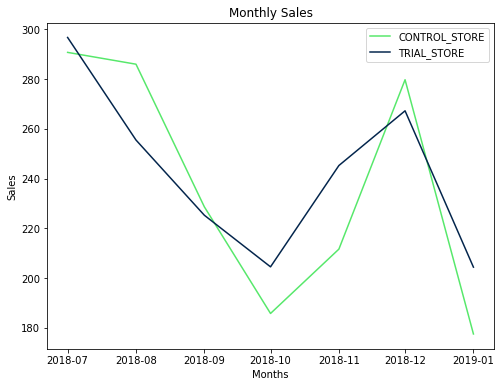

In [61]:
#plot sales of trial and control store
plt.figure(figsize = (8,6))
colors = ['#57e86b','#03254c']
for i in range(len(colors)):
    plt.plot(sales_plot[sales_plot.columns[i]],color = colors[i])
plt.title('Monthly Sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend(sales_plot.columns)
plt.gird()
plt.show()

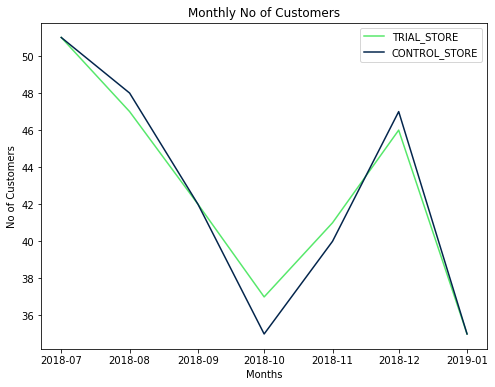

In [28]:
#create customer plot data
trial_customers = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', ['MONTH_ID','MONTHLY_CUSTOMER']]
trial_customers.set_index('MONTH_ID',inplace = True)
trial_customers.rename(columns = {'MONTHLY_CUSTOMER': 'TRIAL_STORE'}, inplace = True)

control_customers = past_sales.loc[past_sales['STORE_TYPE']== 'Control',['MONTH_ID','MONTHLY_CUSTOMER']]
control_customers.set_index('MONTH_ID',inplace = True)
control_customers.rename(columns = {'MONTHLY_CUSTOMER': 'CONTROL_STORE'}, inplace = True)

customers_plot = pd.concat([trial_customers, control_customers], axis = 1)

#plot number of customers of control and trial store
plt.figure(figsize = (8,6))
colors = ['#03254c','#57e86b']
for i in range(len(colors)):
    plt.plot(customers_plot[customers_plot.columns[i]],color = colors[i])
plt.title('Monthly No of Customers')
plt.xlabel('Months')
plt.ylabel('No of Customers')
plt.legend(customers_plot.columns)
plt.gird()
plt.show()

The sales and number of customers are trending in a similar way!

### Assessment of trial store 77 

#### Assessment of monthly sales 

The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

In [29]:
#Scaling pre-trial control sales to match pre-trial store sales
trial_sum = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', 'MONTHLY_SALES'].sum()
control_sum = past_sales.loc[past_sales['STORE_TYPE'] == 'Control', 'MONTHLY_SALES'].sum()
scaling_factor = trial_sum/control_sum

#Apply the scaling factor to control store
scaled_control_sales = data[['MONTH_ID','STORE_NBR','MONTHLY_SALES']]
scaled_control_sales = scaled_control_sales.loc[scaled_control_sales['STORE_NBR']==control_store]
scaled_control_sales.set_index('MONTH_ID',inplace = True)
scaled_control_sales['CONTROL_SALES'] = scaled_control_sales['MONTHLY_SALES'] * scaling_factor
scaled_control_sales.drop_duplicates(inplace = True)
scaled_control_sales.drop(columns = ['STORE_NBR','MONTHLY_SALES'],inplace = True)
scaled_control_sales

,CONTROL_SALES
MONTH_ID,
2018-10,190.125
2018-12,286.250
2018-09,234.000
2019-05,352.500
2019-04,162.375
2018-08,292.750
2019-03,203.750
2019-01,181.625
2019-02,249.750


Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [30]:
#Get trial store sales
trial_period_sales = data[['MONTH_ID','STORE_NBR','MONTHLY_SALES']]
trial_period_sales = trial_period_sales.loc[trial_period_sales['STORE_NBR']==trial_store]
trial_period_sales.set_index('MONTH_ID',inplace = True)
trial_period_sales.drop_duplicates(inplace = True)
trial_period_sales.rename(columns = {'MONTHLY_SALES': 'TRIAL_SALES'}, inplace = True)
trial_period_sales.drop(columns = ['STORE_NBR'],inplace = True)
trial_period_sales

,TRIAL_SALES
MONTH_ID,
2019-03,278.500
2019-04,263.500
2018-09,225.250
2019-02,235.000
2019-01,204.375
2019-05,299.250
2019-06,264.750
2018-07,296.750
2018-08,255.500


In [31]:
pct_diff = pd.concat([trial_period_sales,scaled_control_sales],axis=1)
pct_diff['PCT_DIFF'] = abs(pct_diff['CONTROL_SALES']-pct_diff['TRIAL_SALES'])/pct_diff['CONTROL_SALES']
pct_diff.reset_index(inplace=True)
pct_diff.head()

,MONTH_ID,TRIAL_SALES,CONTROL_SALES,PCT_DIFF
0,2018-07,296.75,297.500,0.002522
1,2018-08,255.50,292.750,0.127197
2,2018-09,225.25,234.000,0.037384
3,2018-10,204.50,190.125,0.075623
4,2018-11,245.25,216.625,0.132080


Let's see if the difference is significant!


In [32]:
#As our null hypothesis is that the trial period is the same as the pre-trial 
#period, let's take the standard deviation based on the scaled percentage difference
#in the pre-trial period 
std_dev = np.std(pct_diff.loc[pct_diff['MONTH_ID'] < '2019-02', 'PCT_DIFF'])
std_dev

0.0463

In [33]:
#There are 8 months in the pre-trial period. Hence, 8 - 1 = 7 degrees of freedom
df = 7
#We will test with a null hypothesis of there being no difference between trial and control store
pct_diff['T_VALUES'] = (pct_diff['PCT_DIFF'] - 0)/std_dev
pct_diff.loc[((pct_diff['MONTH_ID'] < '2019-05') & (pct_diff['MONTH_ID'] > '2019-01'))]

,MONTH_ID,TRIAL_SALES,CONTROL_SALES,PCT_DIFF,T_VALUES
7,2019-02,235.0,249.750,0.059052,1.275391
8,2019-03,278.5,203.750,0.366943,7.925781
9,2019-04,263.5,162.375,0.622559,13.445312


In [34]:
t_95_value = t.ppf(0.95, df)
t_95_value

1.894578605061305

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.


In [35]:
sales_plot = pct_diff[['MONTH_ID','TRIAL_SALES','CONTROL_SALES']]
sales_plot

,MONTH_ID,TRIAL_SALES,CONTROL_SALES
0,2018-07,296.750,297.500
1,2018-08,255.500,292.750
2,2018-09,225.250,234.000
3,2018-10,204.500,190.125
4,2018-11,245.250,216.625
5,2018-12,267.250,286.250
6,2019-01,204.375,181.625
7,2019-02,235.000,249.750
8,2019-03,278.500,203.750
9,2019-04,263.500,162.375


In [36]:
sales_plot['95TH_CONFIDENCE'] = sales_plot['CONTROL_SALES']*(1 + std_dev * 2)
sales_plot['5TH_CONFIDENCE'] = sales_plot['CONTROL_SALES']*(1 - std_dev * 2)
sales_plot

C:\Users\workt\AppData\Local\Temp/ipykernel_15368/1846057874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_plot['95TH_CONFIDENCE'] = sales_plot['CONTROL_SALES']*(1 + std_dev * 2)


,MONTH_ID,TRIAL_SALES,CONTROL_SALES,95TH_CONFIDENCE,5TH_CONFIDENCE
0,2018-07,296.750,297.500,325.000,270.000
1,2018-08,255.500,292.750,320.000,265.500
2,2018-09,225.250,234.000,255.750,212.250
3,2018-10,204.500,190.125,207.750,172.500
4,2018-11,245.250,216.625,236.750,196.500
5,2018-12,267.250,286.250,312.750,259.750
6,2019-01,204.375,181.625,198.500,164.750
7,2019-02,235.000,249.750,273.000,226.625
8,2019-03,278.500,203.750,222.625,184.875
9,2019-04,263.500,162.375,177.500,147.250


In [37]:
sales_plot['MONTH_ID'] = pd.to_datetime(sales_plot['MONTH_ID'].astype('str'),format = '%Y-%m')
sales_plot.set_index('MONTH_ID',inplace = True)

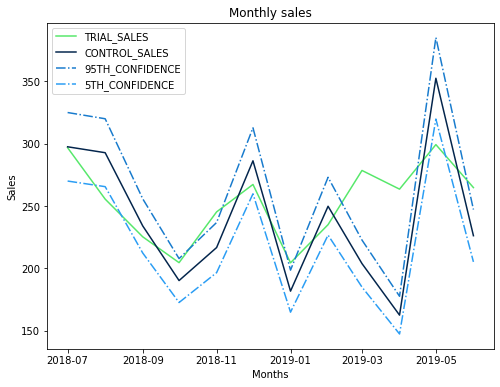

In [38]:
colors = ['#03254c','#57e86b','#187bcd','#2a9df4']
#plot sales of control and trial store
plt.figure(figsize = (8,6))
for i in range(4):
    if (i == 2) | (i == 3):        
        linestyle = '-.'
    else: 
        linestyle = '-'
    plt.plot(sales_plot[sales_plot.columns[i]],color = colors[i], linestyle = linestyle)

plt.title('Monthly sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend(sales_plot.columns)
plt.gird()
plt.show()

The results show that the trial in store 77 is **significantly different** to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in **two of the three trial months**.

#### Assessment of monthly number of customers 

In [39]:
#Scaling pre-trial control customers to match pre-trial trial store customers
trial_sum = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', 'MONTHLY_CUSTOMER'].sum()
control_sum = past_sales.loc[past_sales['STORE_TYPE'] == 'Control', 'MONTHLY_CUSTOMER'].sum()
scaling_factor = trial_sum/control_sum

#Apply the scaling factor to control store
scaled_control_cust = data[['MONTH_ID','STORE_NBR','MONTHLY_CUSTOMER']]
scaled_control_cust = scaled_control_cust.loc[scaled_control_cust['STORE_NBR']==control_store]
scaled_control_cust.drop_duplicates(inplace = True)
scaled_control_cust.rename(columns = {'MONTHLY_CUSTOMER': 'CONTROL_CUST'}, inplace = True)
scaled_control_cust.drop(columns = ['STORE_NBR'],inplace = True)
scaled_control_cust.set_index('MONTH_ID',inplace = True)
scaled_control_cust

,CONTROL_CUST
MONTH_ID,
2018-10,35
2018-12,47
2018-09,42
2019-05,57
2019-04,30
2018-08,48
2019-03,40
2019-01,35
2019-02,45


In [40]:
#Get trial store number of customers
trial_period_cust = data[['MONTH_ID','STORE_NBR','MONTHLY_CUSTOMER']]
trial_period_cust = trial_period_cust.loc[trial_period_cust['STORE_NBR']==trial_store]
trial_period_cust.drop_duplicates(inplace = True)
trial_period_cust.rename(columns = {'MONTHLY_CUSTOMER': 'TRIAL_CUST'}, inplace = True)
trial_period_cust.drop(columns = ['STORE_NBR'],inplace = True)
trial_period_cust.set_index('MONTH_ID',inplace = True)
trial_period_cust

,TRIAL_CUST
MONTH_ID,
2019-03,50
2019-04,47
2018-09,42
2019-02,45
2019-01,35
2019-05,55
2019-06,41
2018-07,51
2018-08,47


In [41]:
pct_diff = pd.concat([trial_period_cust,scaled_control_cust],axis=1)
pct_diff['PCT_DIFF'] = abs(pct_diff['CONTROL_CUST']-pct_diff['TRIAL_CUST'])/pct_diff['CONTROL_CUST']
pct_diff.reset_index(inplace=True)
pct_diff

,MONTH_ID,TRIAL_CUST,CONTROL_CUST,PCT_DIFF
0,2018-07,51,51,0.000000
1,2018-08,47,48,0.020833
2,2018-09,42,42,0.000000
3,2018-10,37,35,0.057143
4,2018-11,41,40,0.025000
5,2018-12,46,47,0.021277
6,2019-01,35,35,0.000000
7,2019-02,45,45,0.000000
8,2019-03,50,40,0.250000
9,2019-04,47,30,0.566667


In [42]:
#As our null hypothesis is that the trial period is the same as the pre-trial 
#period, let's take the standard deviation based on the scaled percentage difference
#in the pre-trial period 
std_dev = np.std(pct_diff.loc[pct_diff['MONTH_ID'] < '2019-02', 'PCT_DIFF'])
std_dev

0.01916652966113954

In [43]:
#There are 8 months in the pre-trial period. Hence, 8 - 1 = 7 degrees of freedom
df = 7
#We will test with a null hypothesis of there being no difference between trial and control store
pct_diff['T_VALUES'] = (pct_diff['PCT_DIFF'] - 0)/std_dev
pct_diff.loc[((pct_diff['MONTH_ID'] < '2019-05') & (pct_diff['MONTH_ID'] > '2019-01'))]

,MONTH_ID,TRIAL_CUST,CONTROL_CUST,PCT_DIFF,T_VALUES
7,2019-02,45,45,0.000000,0.000000
8,2019-03,50,40,0.250000,13.043571
9,2019-04,47,30,0.566667,29.565429


In [44]:
t_95_value = t.ppf(0.95, df)
t_95_value

1.894578605061305

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in number of customers in the trial store in March and April is statistically greater than in the control store.

Let's create a more visual version of this by plotting the number of customers of the control store, the number of customers of the trial stores and the 95th percentile value of number of customers of the control store.


In [45]:
cust_plot = pct_diff[['MONTH_ID','TRIAL_CUST','CONTROL_CUST']]
cust_plot

,MONTH_ID,TRIAL_CUST,CONTROL_CUST
0,2018-07,51,51
1,2018-08,47,48
2,2018-09,42,42
3,2018-10,37,35
4,2018-11,41,40
5,2018-12,46,47
6,2019-01,35,35
7,2019-02,45,45
8,2019-03,50,40
9,2019-04,47,30


In [47]:
cust_plot['95TH_CONFIDENCE'] = cust_plot['CONTROL_CUST']*(1 + std_dev * 2)
cust_plot['5TH_CONFIDENCE'] = cust_plot['CONTROL_CUST']*(1 - std_dev * 2)
cust_plot

,MONTH_ID,TRIAL_CUST,CONTROL_CUST,95TH_CONFIDENCE,5TH_CONFIDENCE
0,2018-07,51,51,52.954986,49.045014
1,2018-08,47,48,49.839987,46.160013
2,2018-09,42,42,43.609988,40.390012
3,2018-10,37,35,36.341657,33.658343
4,2018-11,41,40,41.533322,38.466678
5,2018-12,46,47,48.801654,45.198346
6,2019-01,35,35,36.341657,33.658343
7,2019-02,45,45,46.724988,43.275012
8,2019-03,50,40,41.533322,38.466678
9,2019-04,47,30,31.149992,28.850008


In [48]:
cust_plot['MONTH_ID'] = pd.to_datetime(cust_plot['MONTH_ID'].astype('str'),format = '%Y-%m')
cust_plot.set_index('MONTH_ID',inplace = True)

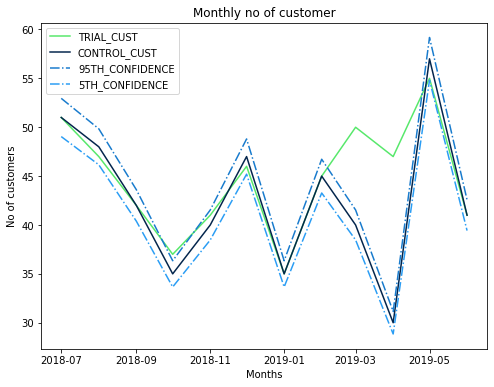

In [49]:
colors = ['#03254c','#57e86b','#187bcd','#2a9df4']
#plot number of customers of control and trial store
plt.figure(figsize = (8,6))
for i in range(4):
    if (i == 2) | (i == 3):        
        linestyle = '-.'
    else: 
        linestyle = '-'
    plt.plot(cust_plot[cust_plot.columns[i]],color = colors[i], linestyle = linestyle)

plt.title('Monthly no of customer')
plt.xlabel('Months')
plt.ylabel('No of customers')
plt.legend(cust_plot.columns)
plt.gird()
plt.show()

Considering the monthly no of customers, the results show that the trial in store 77 is **significantly different** to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in **two of the three trial months**.

In conclusion, the trial in store 77 is **significantly different** to control store 233 in the **two of three trial months** in term of monthly sales and monthly number of customers

# Trial Store 86

### Select control store 

In [62]:
#Calculate correlations against store 86 using total sales and number of customers
trial_store = 86
corr_sales = cal_corr(input_data,'MONTHLY_SALES',trial_store)
corr_customers = cal_corr(input_data,'MONTHLY_CUSTOMER',trial_store)

#Calculate magnitude distance against store 86 using total sales and number of customers
mag_sales = cal_magnitude(input_data,'MONTHLY_SALES',trial_store)
mag_customers = cal_magnitude(input_data,'MONTHLY_CUSTOMER',trial_store)

C:\Users\workt\anaconda3\lib\site-packages\pandas\core\nanops.py:146: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


In [63]:
#Merge sales score
score_sales = corr_sales.merge(mag_sales, how = 'left', on = 'STORE_NBR')
#Merge no of customer score
score_customers = corr_customers.merge(mag_customers, how = 'left', on = 'STORE_NBR')

In [64]:
#Drop 86
index_drop = score_sales[score_sales['STORE_NBR']==trial_store].index
score_sales.drop(index_drop, inplace = True)
#Calculate control score for sales
score_sales['SCORE_SALES'] = (score_sales['CORR'] + score_sales['MAGNITUDE'])/2
score_sales.head()

,STORE_NBR,CORR,MAGNITUDE,SCORE_SALES
0,1,0.444649,0.488525,0.466587
1,2,0.403303,0.322266,0.362784
2,3,0.263501,0.506836,0.385168
3,4,0.037508,0.636230,0.336869
4,5,0.235580,0.580566,0.408073


In [65]:
#Drop store 86
score_customers.drop(index_drop, inplace = True)
#Create control_store column
score_customers['SCORE_CUSTOMERS'] = (score_customers['CORR'] + score_customers['MAGNITUDE'])/2
score_customers.head()

,STORE_NBR,CORR,MAGNITUDE,SCORE_CUSTOMERS
0,1,0.485831,0.510204,0.498018
1,2,0.086161,0.428571,0.257366
2,3,0.353786,0.563025,0.458405
3,4,0.169608,0.537815,0.353712
4,5,0.253229,0.714286,0.483757


In [66]:
score_control = score_sales.merge(score_customers, how = 'left', on = 'STORE_NBR')
score_control['FINAL_SCORE'] = (score_control['SCORE_SALES'] + score_control['SCORE_CUSTOMERS'])/2
score_control.sort_values(by = 'FINAL_SCORE',ascending = False, inplace = True)
score_control.head()

,STORE_NBR,CORR_x,MAGNITUDE_x,SCORE_SALES,CORR_y,MAGNITUDE_y,SCORE_CUSTOMERS,FINAL_SCORE
146,155,0.877930,0.741699,0.809815,0.942876,0.523810,0.733343,0.771579
101,109,0.787909,0.606934,0.697421,0.770778,0.714286,0.742532,0.719977
21,23,0.784862,0.364990,0.574926,0.943559,0.614286,0.778922,0.676924
256,270,0.729909,0.516113,0.623011,0.767267,0.650794,0.709030,0.666021
106,114,0.734822,0.528809,0.631815,0.855339,0.471429,0.663384,0.647600


As we can see, store 155 is the store with the highest score. Hence, store 155 is selected as the control store

In [67]:
control_store = 155

In [68]:
past_sales['MONTH_ID'] = pd.to_datetime(past_sales['MONTH_ID'].astype('str'),format = '%Y-%m')

In [70]:
past_sales['STORE_TYPE'] = past_sales['STORE_NBR'].apply(store_type)

In [71]:
past_sales[past_sales['STORE_TYPE'] == 'Control']

,STORE_NBR,MONTH_ID,MONTHLY_SALES,MONTHLY_CUSTOMER,TRANSACTION_PER_CUSTOMER,QTY_PER_CUSTOMER,AVERAGE_PRICE,STORE_TYPE
151873,155,2019-01-01,874.5,96,1.312500,2.625000,3.470238,Control
151879,155,2018-08-01,782.5,91,1.318681,2.516484,3.417031,Control
151884,155,2018-10-01,964.0,108,1.259259,2.518519,3.544118,Control
151888,155,2018-07-01,924.5,101,1.237624,2.475248,3.698000,Control
151889,155,2018-11-01,899.0,101,1.336634,2.673267,3.329630,Control
151891,155,2018-12-01,850.0,97,1.247423,2.494845,3.512397,Control
151904,155,2018-09-01,1014.5,103,1.407767,2.815534,3.498276,Control


In [72]:
trial_sales = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', ['MONTH_ID','MONTHLY_SALES']]
trial_sales.set_index('MONTH_ID',inplace = True)
trial_sales.rename(columns = {'MONTHLY_SALES': 'TRIAL_STORE'}, inplace = True)

control_sales = past_sales.loc[past_sales['STORE_TYPE']== 'Control',['MONTH_ID','MONTHLY_SALES']]
control_sales.set_index('MONTH_ID',inplace = True)
control_sales.rename(columns = {'MONTHLY_SALES': 'CONTROL_STORE'}, inplace = True)

sales_plot = pd.concat([control_sales, trial_sales], axis = 1)
sales_plot

,CONTROL_STORE,TRIAL_STORE
MONTH_ID,,
2018-07-01,924.5,892.0
2018-08-01,782.5,764.0
2018-09-01,1014.5,914.5
2018-10-01,964.0,948.5
2018-11-01,899.0,918.0
2018-12-01,850.0,841.0
2019-01-01,874.5,841.5


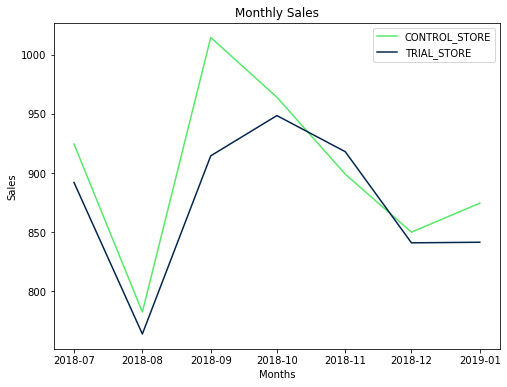

In [75]:
#plot sales of trial and control store
plt.figure(figsize = (8,6))
colors = ['#57e86b','#03254c']
for i in range(len(colors)):
    plt.plot(sales_plot[sales_plot.columns[i]],color = colors[i])
plt.title('Monthly Sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend(sales_plot.columns)
plt.gird()
plt.show()

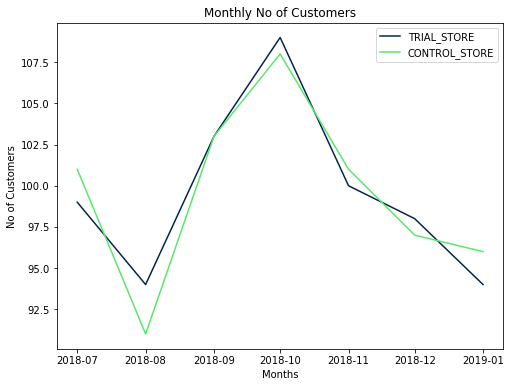

In [74]:
#create customer plot data
trial_customers = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', ['MONTH_ID','MONTHLY_CUSTOMER']]
trial_customers.set_index('MONTH_ID',inplace = True)
trial_customers.rename(columns = {'MONTHLY_CUSTOMER': 'TRIAL_STORE'}, inplace = True)

control_customers = past_sales.loc[past_sales['STORE_TYPE']== 'Control',['MONTH_ID','MONTHLY_CUSTOMER']]
control_customers.set_index('MONTH_ID',inplace = True)
control_customers.rename(columns = {'MONTHLY_CUSTOMER': 'CONTROL_STORE'}, inplace = True)

customers_plot = pd.concat([trial_customers, control_customers], axis = 1)

#plot number of customers of control and trial store
plt.figure(figsize = (8,6))
colors = ['#03254c','#57e86b']
for i in range(len(colors)):
    plt.plot(customers_plot[customers_plot.columns[i]],color = colors[i])
plt.title('Monthly No of Customers')
plt.xlabel('Months')
plt.ylabel('No of Customers')
plt.legend(customers_plot.columns)
plt.gird()
plt.show()

The sales and number of customers are trending in a similar way!

### Assessment of trial store 77 

#### Assessment of monthly sales 

In [76]:
#Scaling pre-trial control sales to match pre-trial store sales
trial_sum = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', 'MONTHLY_SALES'].sum()
control_sum = past_sales.loc[past_sales['STORE_TYPE'] == 'Control', 'MONTHLY_SALES'].sum()
scaling_factor = trial_sum/control_sum

#Apply the scaling factor to control store
scaled_control_sales = data[['MONTH_ID','STORE_NBR','MONTHLY_SALES']]
scaled_control_sales = scaled_control_sales.loc[scaled_control_sales['STORE_NBR']==control_store]
scaled_control_sales.set_index('MONTH_ID',inplace = True)
scaled_control_sales['CONTROL_SALES'] = scaled_control_sales['MONTHLY_SALES'] * scaling_factor
scaled_control_sales.drop_duplicates(inplace = True)
scaled_control_sales.drop(columns = ['STORE_NBR','MONTHLY_SALES'],inplace = True)
scaled_control_sales

,CONTROL_SALES
MONTH_ID,
2019-06,831.5
2019-02,864.5
2019-01,848.5
2019-03,780.5
2019-04,819.5
2018-08,759.0
2018-10,935.5
2018-07,897.0
2018-11,872.0


In [77]:
#Get trial store sales
trial_period_sales = data[['MONTH_ID','STORE_NBR','MONTHLY_SALES']]
trial_period_sales = trial_period_sales.loc[trial_period_sales['STORE_NBR']==trial_store]
trial_period_sales.set_index('MONTH_ID',inplace = True)
trial_period_sales.drop_duplicates(inplace = True)
trial_period_sales.rename(columns = {'MONTHLY_SALES': 'TRIAL_SALES'}, inplace = True)
trial_period_sales.drop(columns = ['STORE_NBR'],inplace = True)
trial_period_sales

,TRIAL_SALES
MONTH_ID,
2018-08,764.0
2018-09,914.5
2019-02,913.0
2018-11,918.0
2018-12,841.0
2019-01,841.5
2019-05,889.5
2018-10,948.5
2019-03,1027.0


In [78]:
pct_diff = pd.concat([trial_period_sales,scaled_control_sales],axis=1)
pct_diff['PCT_DIFF'] = abs(pct_diff['CONTROL_SALES']-pct_diff['TRIAL_SALES'])/pct_diff['CONTROL_SALES']
pct_diff.reset_index(inplace=True)
pct_diff.head()

,MONTH_ID,TRIAL_SALES,CONTROL_SALES,PCT_DIFF
0,2018-07,892.0,897.0,0.005573
1,2018-08,764.0,759.0,0.006588
2,2018-09,914.5,984.5,0.071106
3,2018-10,948.5,935.5,0.013893
4,2018-11,918.0,872.0,0.052765


In [79]:
#As our null hypothesis is that the trial period is the same as the pre-trial 
#period, let's take the standard deviation based on the scaled percentage difference
#in the pre-trial period 
std_dev = np.std(pct_diff.loc[pct_diff['MONTH_ID'] < '2019-02', 'PCT_DIFF'])
std_dev

0.02403

In [84]:
#There are 8 months in the pre-trial period. Hence, 8 - 1 = 7 degrees of freedom
df = 7
#We will test with a null hypothesis of there being no difference between trial and control store
pct_diff['T_VALUES'] = (pct_diff['PCT_DIFF'] - 0)/std_dev

In [85]:
sales_plot = pct_diff[['MONTH_ID','TRIAL_SALES','CONTROL_SALES']]
sales_plot

,MONTH_ID,TRIAL_SALES,CONTROL_SALES
0,2018-07,892.0,897.0
1,2018-08,764.0,759.0
2,2018-09,914.5,984.5
3,2018-10,948.5,935.5
4,2018-11,918.0,872.0
5,2018-12,841.0,824.5
6,2019-01,841.5,848.5
7,2019-02,913.0,864.5
8,2019-03,1027.0,780.5
9,2019-04,848.0,819.5


In [87]:
sales_plot['95TH_CONFIDENCE'] = sales_plot['CONTROL_SALES']*(1 + std_dev * 2)
sales_plot['5TH_CONFIDENCE'] = sales_plot['CONTROL_SALES']*(1 - std_dev * 2)
sales_plot

,MONTH_ID,TRIAL_SALES,CONTROL_SALES,95TH_CONFIDENCE,5TH_CONFIDENCE
0,2018-07,892.0,897.0,940.0,854.0
1,2018-08,764.0,759.0,795.5,722.5
2,2018-09,914.5,984.5,1032.0,937.5
3,2018-10,948.5,935.5,980.5,890.5
4,2018-11,918.0,872.0,913.5,830.5
5,2018-12,841.0,824.5,864.0,785.0
6,2019-01,841.5,848.5,889.0,808.0
7,2019-02,913.0,864.5,906.0,823.0
8,2019-03,1027.0,780.5,818.0,743.0
9,2019-04,848.0,819.5,858.5,780.5


In [88]:
sales_plot['MONTH_ID'] = pd.to_datetime(sales_plot['MONTH_ID'].astype('str'),format = '%Y-%m')
sales_plot.set_index('MONTH_ID',inplace = True)

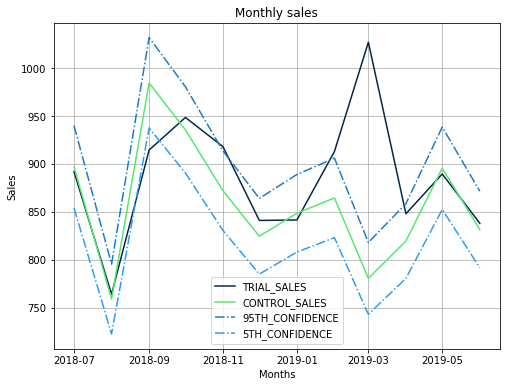

In [90]:
colors = ['#03254c','#57e86b','#187bcd','#2a9df4']
#plot sales of control and trial store
plt.figure(figsize = (8,6))
for i in range(4):
    if (i == 2) | (i == 3):        
        linestyle = '-.'
    else: 
        linestyle = '-'
    plt.plot(sales_plot[sales_plot.columns[i]],color = colors[i], linestyle = linestyle)

plt.title('Monthly sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend(sales_plot.columns)
plt.grid()
plt.show()

Consider the monthly sales, the results show that the trial in store 86 is not significantly different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

#### Assessment of monthly number of customers 

In [91]:
#Scaling pre-trial control customers to match pre-trial trial store customers
trial_sum = past_sales.loc[past_sales['STORE_TYPE'] == 'Trial', 'MONTHLY_CUSTOMER'].sum()
control_sum = past_sales.loc[past_sales['STORE_TYPE'] == 'Control', 'MONTHLY_CUSTOMER'].sum()
scaling_factor = trial_sum/control_sum

#Apply the scaling factor to control store
scaled_control_cust = data[['MONTH_ID','STORE_NBR','MONTHLY_CUSTOMER']]
scaled_control_cust = scaled_control_cust.loc[scaled_control_cust['STORE_NBR']==control_store]
scaled_control_cust.drop_duplicates(inplace = True)
scaled_control_cust.rename(columns = {'MONTHLY_CUSTOMER': 'CONTROL_CUST'}, inplace = True)
scaled_control_cust.drop(columns = ['STORE_NBR'],inplace = True)
scaled_control_cust.set_index('MONTH_ID',inplace = True)
scaled_control_cust

,CONTROL_CUST
MONTH_ID,
2019-06,95
2019-02,95
2019-01,96
2019-03,94
2019-04,99
2018-08,91
2018-10,108
2018-07,101
2018-11,101


In [92]:
#Get trial store no of customers
trial_period_cust = data[['MONTH_ID','STORE_NBR','MONTHLY_CUSTOMER']]
trial_period_cust = trial_period_cust.loc[trial_period_cust['STORE_NBR']==trial_store]
trial_period_cust.drop_duplicates(inplace = True)
trial_period_cust.rename(columns = {'MONTHLY_CUSTOMER': 'TRIAL_CUST'}, inplace = True)
trial_period_cust.drop(columns = ['STORE_NBR'],inplace = True)
trial_period_cust.set_index('MONTH_ID',inplace = True)
trial_period_cust

,TRIAL_CUST
MONTH_ID,
2018-08,94
2018-09,103
2019-02,107
2018-11,100
2018-12,98
2019-01,94
2019-05,104
2018-10,109
2019-03,115


In [93]:
pct_diff = pd.concat([trial_period_cust,scaled_control_cust],axis=1)
pct_diff['PCT_DIFF'] = abs(pct_diff['CONTROL_CUST']-pct_diff['TRIAL_CUST'])/pct_diff['CONTROL_CUST']
pct_diff.reset_index(inplace=True)
pct_diff

,MONTH_ID,TRIAL_CUST,CONTROL_CUST,PCT_DIFF
0,2018-07,99,101,0.019802
1,2018-08,94,91,0.032967
2,2018-09,103,103,0.000000
3,2018-10,109,108,0.009259
4,2018-11,100,101,0.009901
5,2018-12,98,97,0.010309
6,2019-01,94,96,0.020833
7,2019-02,107,95,0.126316
8,2019-03,115,94,0.223404
9,2019-04,105,99,0.060606


In [94]:
#As our null hypothesis is that the trial period is the same as the pre-trial 
#period, let's take the standard deviation based on the scaled percentage difference
#in the pre-trial period 
std_dev = np.std(pct_diff.loc[pct_diff['MONTH_ID'] < '2019-02', 'PCT_DIFF'])
std_dev

0.009894651119759365

In [95]:
#There are 8 months in the pre-trial period. Hence, 8 - 1 = 7 degrees of freedom
df = 7
#We will test with a null hypothesis of there being no difference between trial and control store
pct_diff['T_VALUES'] = (pct_diff['PCT_DIFF'] - 0)/std_dev

In [97]:
cust_plot = pct_diff[['MONTH_ID','TRIAL_CUST','CONTROL_CUST']]
cust_plot.head()

,MONTH_ID,TRIAL_CUST,CONTROL_CUST
0,2018-07,99,101
1,2018-08,94,91
2,2018-09,103,103
3,2018-10,109,108
4,2018-11,100,101


In [99]:
cust_plot['95TH_CONFIDENCE'] = cust_plot['CONTROL_CUST']*(1 + std_dev * 2)
cust_plot['5TH_CONFIDENCE'] = cust_plot['CONTROL_CUST']*(1 - std_dev * 2)
cust_plot.head()

,MONTH_ID,TRIAL_CUST,CONTROL_CUST,95TH_CONFIDENCE,5TH_CONFIDENCE
0,2018-07,99,101,102.998720,99.001280
1,2018-08,94,91,92.800827,89.199173
2,2018-09,103,103,105.038298,100.961702
3,2018-10,109,108,110.137245,105.862755
4,2018-11,100,101,102.998720,99.001280


In [100]:
cust_plot['MONTH_ID'] = pd.to_datetime(cust_plot['MONTH_ID'].astype('str'),format = '%Y-%m')
cust_plot.set_index('MONTH_ID',inplace = True)

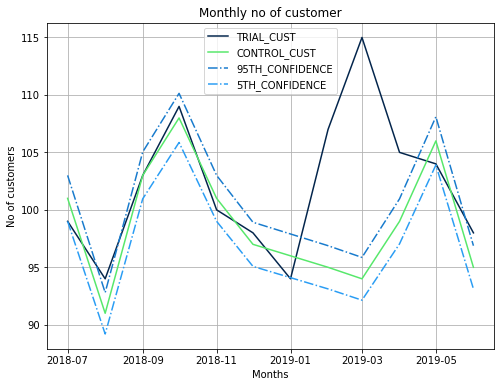

In [102]:
colors = ['#03254c','#57e86b','#187bcd','#2a9df4']
#plot number of customers of control and trial store
plt.figure(figsize = (8,6))
for i in range(4):
    if (i == 2) | (i == 3):        
        linestyle = '-.'
    else: 
        linestyle = '-'
    plt.plot(cust_plot[cust_plot.columns[i]],color = colors[i], linestyle = linestyle)

plt.title('Monthly no of customer')
plt.xlabel('Months')
plt.ylabel('No of customers')
plt.legend(cust_plot.columns)
plt.grid()
plt.show()

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.
